# About

This notebook is the follow up to the `Tutorial 1: Data Import, Labeling, and Export` notebook. 

It will mainly cover the training, validation, and testing of statistical inference (i.e., machine learning) models. The goal is to create supervised regression models that can predict the concentration and identity of neurotransmitters from a set of unknown voltammograms, having been trained on a data set of known voltammograms. 

We will start with PCR and PLSR models, as these are the most common in the fast neurochemical voltammetry field. Since these two model types have many similarities, we'll use helper functions common between them.

The user should be familiar with how machine learning models such as these are used for voltammetry data. We cover only how to implement these models.

# Importing and Labeling

To make this notebook cleaner, we're going to list all our import packages and define all our helper functions in a separate notebook called `myFunctions_dev`. That way, we can simply import this notebook here once, and have everything defined in a single line of code.

To import this notebook, just make sure it is in the same file location as the notebook you are trying to import it into.

In [1]:
from ipynb.fs.full.myFunctions_dev import *

Let's go ahead and import and label our data. This process is largely the same as in `Tutorial 1`, see that notebook for more details. A few key differences will be noted here. But note how using the separate `myFunctions_dev` notebook, this is all done in only a couple lines of code.

We start by defining our analyte list and color coding. We'll also define what type of model we want to build (here, partial least squares regression, or PLSR).

In [2]:
analyte_list=['DA','HT']
cmap = {'DA':'r','HT':'b'}
modelChoice = 'PLSR'

A key difference here is that we will define a training set and a test set. Note the difference in the variables assigned to the file name in the cells below (e.g., train versus test).

The training set contains samples A-P in alphabetical order, with some blank samples (denoted 0) mixed in. In total, we have 20 training samples. Instead of extracting just one voltammogram per injection, we extracted 51 voltammograms per injection. This was done in SeroWare SeroDataProcess (see www.github.com/csmova/seroware/wiki for more information). Because we performed flow cell injections that were 20 seconds long, we took the last 5 seconds of the injection (where the signal is most stable). At a sampling speed of 1 MHz, this results in 51 voltammograms per injection, meaning 1020 voltammograms total.

We're also going to include some background signal voltammograms, i.e., voltammograms obtained not during an actual injection, but just while buffer is flowing through the flow cell in between injections. This helps account for noise and drift outside of the `0` samples, which account for injection noise. We've found that including these samples great helps with accuracy and drift correction. You can try for your own data and see if it helps. Let us know!

We'll extract the 5 seconds before each injection (only for the training set!) and label them as `0bs` for a blank of the background signal. Because we'll do this for every sample, it will double all training data size to 2040.

This is shown below. The `0bs` samples are highlighted in yellow. The other samples (`A`, `B`,...) are shown in blue. Both represent roughly ~5s of data.

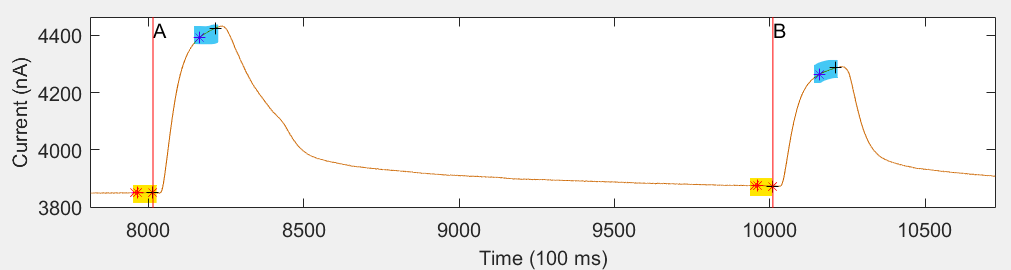

In [3]:
X_train, train_labels = import_data(r"D:\demo\r1s1wf6_02152023_train_0bs.mat",
                                   analyte_list)

remove_delimiter(X_train)

Again, try to give descriptive file names. Here, we denote the file as {waveform}\_{date}\_{train or test set data}\_{whether or not it includes 0bs samples}.

You could also include the electrode length, who performed the experiment, etc. Regardless, all metadata should be included along with the data in some format, even if not in the file name.

In [4]:
X_train.head

<bound method NDFrame.head of                0           0           0           0           0           0  \
0    -303.193704 -302.549088 -303.193704 -303.193704 -303.516013 -302.871396   
1    -303.193704 -303.193704 -303.193704 -303.516013 -302.871396 -303.193704   
2    -303.193704 -303.516013 -303.193704 -302.871396 -302.871396 -303.838321   
3    -302.549088 -302.549088 -302.871396 -303.516013 -303.193704 -302.871396   
4    -303.193704 -302.871396 -303.193704 -303.516013 -303.193704 -302.226779   
...          ...         ...         ...         ...         ...         ...   
5795 -383.126197 -383.448505 -383.126197 -382.803888 -383.448505 -383.770814   
5796 -383.126197 -383.770814 -383.770814 -382.803888 -383.126197 -384.093122   
5797 -383.126197 -382.803888 -383.448505 -383.770814 -383.448505 -383.448505   
5798 -382.803888 -383.126197 -383.448505 -382.481580 -383.126197 -383.126197   
5799 -382.803888 -383.126197 -382.481580 -383.126197 -383.126197 -383.448505   

         

Meanwhile, the test set contains four samples denoted with a T (for Test): `T1`, `T2`, `T3`, `T4`, along with a `0`. None of this samples will be included in the training set. This `X_test` set is only used for testing or evaluating the final model (trained on `X_train`). Because it contains 5 injections, each with 51 voltammgrams, we have 255 voltammograms total (columns). We don't need to include any `0bs` for the test set, unless we want to.

In [5]:
X_test, test_labels = import_data(r"D:\demo\r1s1wf6_02152023_test.mat",
                                   analyte_list)

remove_delimiter(X_test)

In [6]:
X_test.head

<bound method NDFrame.head of               T1          T1          T1          T1          T1          T1  \
0    -302.549088 -302.871396 -302.871396 -303.193704 -303.516013 -302.871396   
1    -302.549088 -303.193704 -302.549088 -302.549088 -302.549088 -302.871396   
2    -302.871396 -302.871396 -302.871396 -303.838321 -302.871396 -303.516013   
3    -302.871396 -303.193704 -303.516013 -302.871396 -302.871396 -303.193704   
4    -302.549088 -302.871396 -303.193704 -302.226779 -302.871396 -303.516013   
...          ...         ...         ...         ...         ...         ...   
5795 -382.803888 -382.803888 -382.803888 -382.481580 -382.481580 -383.126197   
5796 -383.126197 -382.481580 -382.803888 -383.126197 -382.481580 -382.481580   
5797 -382.803888 -382.481580 -382.803888 -382.481580 -382.159271 -382.481580   
5798 -382.481580 -381.836963 -382.481580 -382.803888 -381.836963 -382.481580   
5799 -382.803888 -382.481580 -382.803888 -383.126197 -382.481580 -382.159271   

         

Occasionally, you may wish to downsample your data for quicker training or memory restrictions. We can do this using the `downsample` helper function. We will not use this here, but some users may find this useful. E.g., to downsample by 10% (every tenth value):

In [7]:
#X_train = downsample(X_train,10)
#print(X_train.head)
#X_test = downsample(X_test,10)
#print(X_test.head)

The remaining steps are similar to the first notebook, with the only difference between that `y_train` and `y_test` labels need separate variables to correspond with `X_train` and `X_test`, respectively. Note, if you are including 0bs samples, make sure to add `0bs` as a `Std ID` to your schema, along with all concnetrations set to 0.

In [8]:
schema = create_schema_from_excel(r"D:\demo\RPV_standards_schema.xlsx",
                                  'standardset03302022')

In [9]:
y_train = label_concentrations(schema,analyte_list,train_labels)

In [10]:
y_test = label_concentrations(schema,analyte_list,test_labels)

As expected, our training and test set labels correspond to the number of voltammograms. 

In [11]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(y_train)
    print('---------------------------')
    print(y_test)

                 DA     HT
peak_labels               
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0               0.0    0.0
0

In just a couple blocks of code, we've imported and labeled all our data. We can plot all our voltammograms quickly using another helper function, `plot_raw_voltammograms`. Note- the more data you have, the longer this will take!

In [ ]:
plot_raw_voltammograms(X_train)

# Pre-processing and Outlier Removal

Let's plot our data using various common pre-processing methods, such as standardization, normalization, and differentiation. This helps get an idea of the spread of our data, and specifically, helps catch outliers.

An important consideration: we do not cover how to background subtract, digitally filter, or perform other user-specific data processing protocols here, for the time being. Ideally, these processes should have occured prior to importing your data into Python. For example, the SeroWare SeroDataProcess module enables background subtraction, digital signal processing, signal averaging, and more. This notebook and database seeks to strike the right balance between processed data versus usable data. If your data has been processed in any way prior to import, this should always be noted!

Here, our data is as raw as possible, having only been extracted using the time stamps from flow cell injections such that we can be sure the concentration labels are correct. No digital filtering, averaging, or background subtraction has been performed.

In [ ]:
plot_preprocessers(X_train)

Another useful way to visualize the data, see the effects of pre-processing, and catch outliers is to run PCA. Our helper function will automatically plot various pre-processed data on the first two PCs, along with sample labels and colored points representing the various concentrations of that sample.

Note how the 0 and 0bs scores are clustered mainly in one quadrant/side of the axes.

In [ ]:
get_PCA(X_train,y_train,analyte_list)

Our data appears to be quite clean. We could perform other outlier tests as desired, such as SPE, Hotelling T2 test, and so forth. These are largely user-dependent. 

Looking at the standardized voltammograms usually catches outliers, especially ones caused by erroneous noise at a certain sampled point. This will cause a large change in the standard deviation of that point, and can be visually spotted by eye. 

A quick trick to identify and remove this voltammogram is given below. Instead of removing the outlier voltammogram, the voltammograms directly before and after it are averaged and used to replace that outlier. Just make sure it isnt a voltammogram that is the first or last in its sample, otherwise the voltammogram will be averaged from two different samples. We use this trick as it prevents sample imbalance when many outliers are present, helps average over noise, and provides a quick work around to having to also update the sample labels.

An example of some visually spotted outliers is shown below (not from this data set).

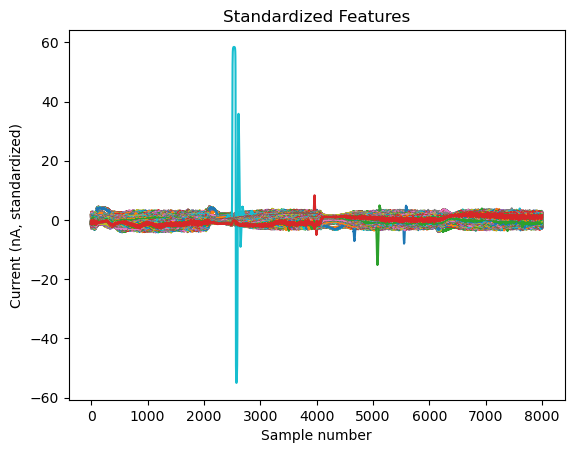

Using the following commands, a given number of samples with points having standard deviations that are outside a desired cut off (i.e., the turqiouse, red, 2 blue, and green abberations above; 5 total) can be averaged out. These single point abberations can occur due to experimental noise.

We won't actually run this code here because our data is clean, but this and other procedures that work well with your data to remove outliers should be used here.

In [ ]:
#outlier_history=[]

In [ ]:
#num_outliers=5

#for i in np.arange(num_outliers):
#    scaledX = pd.DataFrame(abs(scale(X_train.T).T))
#    with pd.option_context('display.max_rows', None,
#                           'display.max_columns', None,
#                           'display.precision', 3,
#                           ):
#        scaled_max = scaledX.max().max()
        #print(scaledX.idxmax(axis=1))

    # Calling getIndexes() function to get
    # the index positions of all occurrences
#    listOfPositions = getIndexes(scaledX,scaled_max)

    #print('Max std dev outlier found at : ')

    # Printing the position
    #for i in range(len(listOfPositions)):
        #print(listOfPositions[i])

#    plt.plot(scaledX.loc[:,listOfPositions[0][1]]);
#    plt.title("Outliers")
#    plt.xlabel("Sample Number")
#    plt.ylabel("Scaled Current (nA)")
    
#    outlier_history.append(listOfPositions[0][1])
#    X_train.iloc[:,listOfPositions[0][1]] = (X_train.iloc[:,listOfPositions[0][1]-1]+X_train.iloc[:,listOfPositions[0][1]+1])/2


#print('Outliers Identified: '+ str(outlier_history));
#plt.show()
#scaledX = pd.DataFrame(scale(X_train.T).T)
#plt.plot(scaledX);
#plt.title("Data with Outliers Removed")
#plt.xlabel("Sample Number")
#plt.ylabel("Scaled Current")
#plt.show()

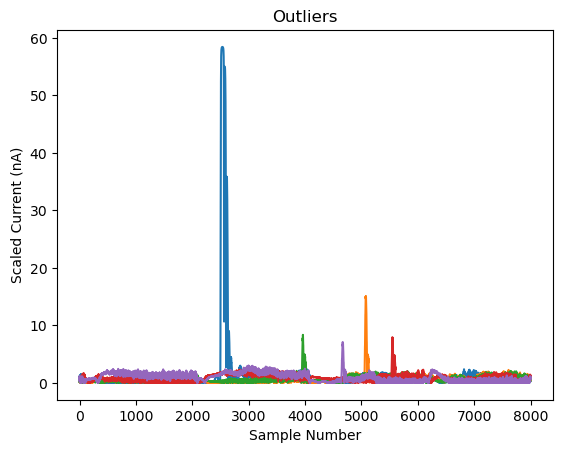

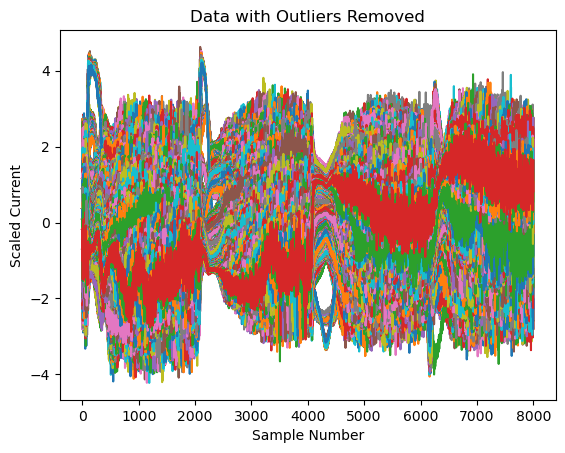

Now our data above is much cleaner. 

You can also drop samples directly from the data frames using the `drop` method. 

In [ ]:
#samples_to_drop=[];
#y_train=y_train.drop([samples_to_drop])
#X_train=X_train.drop(columns=samples_to_drop)

# Model Selection

After exploring the various pre-processing effects and removing outliers, out data should be in the cleanest possible format. We now need to decide on a single pre-processing method to use for our model (we can always try multiple and compare, but the pre-processing must be consistent within that model!).

We've created a helper function to set your pre-process protocol. Note that pre-processers are `fit` to the training data, such that the pre-processing parameters can be applied to `transform` the unknown test data without data leakage. This is why it is important to keep your preprocessing procedures consistent.

Here, we are going to normalize our data, which requires setting the type of norm (here, `max`).

In [12]:
preprocesser = set_preprocess('Normalize Samples',X_train,myNorm='max')

The reason we set our preprocessor as a variable is so we can iincorporate into a sci-kit learn pipeline. This allows for consistency in modeling. For example, the below line of code fully trains a model of our choice (PLSR or PCR) on our data using our desired pre-processing. It returns how much of the variance in the data is explained by the model, broken down by the number of components (for example, 1-20 if we set `nComps = 20`). Although we could explore the thousands of components, usually by ~20, the variance explained levels off (and the model starts to overfit!), so its not worth the wasted computation time.

In [13]:
nComps = 20

In [14]:
get_R2Y(nComps,X_train,y_train,analyte_list,modelChoice,preprocesser,cmap)

KeyboardInterrupt: 

Similarly, we can look at the cross-validated variance explained. The default cross validation is 5-fold. This process can take quite a while depending on what you set `nComps` to, and the size of your dataset. 

In [ ]:
get_Q2Y(nComps,X_train,y_train,analyte_list,modelChoice,preprocesser,cmap)

You can also use these functions to look over various pre-processing and/or visualize R2Y and Q2Y on the same plot. 
For example:

In [ ]:
pps = ['Normalize Samples','Scale Features',]

nrms=['max','l1','l2']

for analyte in analyte_list:
    for pp in pps:
        if pp == 'Normalize Samples':
            for nrm in nrms:
                preprocesser = set_preprocess(pp,X_train,myNorm=nrm)
                print(pp,nrm)
                get_R2Y(nComps,X_train,y_train,[analyte],modelChoice,preprocesser,cmap)
                get_Q2Y(nComps,X_train,y_train,[analyte],modelChoice,preprocesser,cmap)
                plt.show()
        else:
            preprocesser = set_preprocess(pp,X_train)
            print(pp)
            get_R2Y(nComps,X_train,y_train,[analyte],modelChoice,preprocesser,cmap)
            get_Q2Y(nComps,X_train,y_train,[analyte],modelChoice,preprocesser,cmap)
            plt.show()

Based on the elbow point of the R2Y and Q2Y plots, we should choose...

Now we can set our final model as such.

In [15]:
finalComps = 15

In [16]:
model = set_model(modelChoice,X_train.T,y_train,finalComps,preprocesser)

                   DA                    HT
0  [0.97874163173255]                   NaN
1                 NaN  [0.9550854361745875]


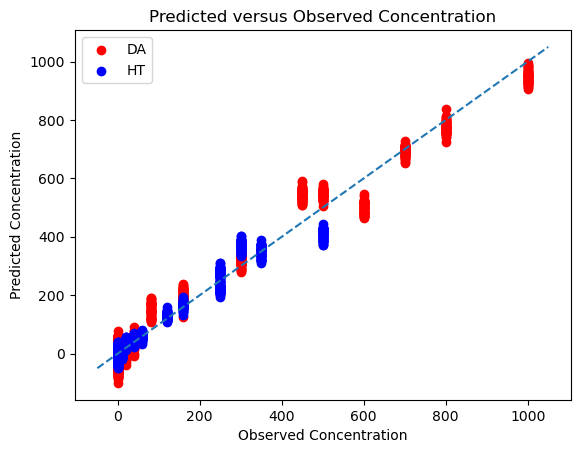

In [17]:
calibration_curves(model,X_train.T,y_train,analyte_list,cmap)

There are many other cross-validation approaches to explore besides k-fold. For example, you can leave-one-out, leave-one-group-out, perform repeated k-fold, etc. See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

Here is an example of Leave One Group Out, where groups are conncentration levels of a given analyte.

Num comps is 15
R2=0.46810681042480706
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0    -1027.109121         0.0   357.662807
1      -41.009155        20.0    20.844439
2       31.170862        40.0    21.823513
3      378.771269        80.0    22.273572
4      240.534426       160.0    22.778323
5      740.044068       300.0    18.884908
6      644.959093       450.0    20.820458
7      717.675160       500.0    16.856498
8      427.441369       600.0    21.365948
9      668.040801       700.0    15.642359
10     679.229051       800.0    19.094532
11     741.042536      1000.0    20.943957


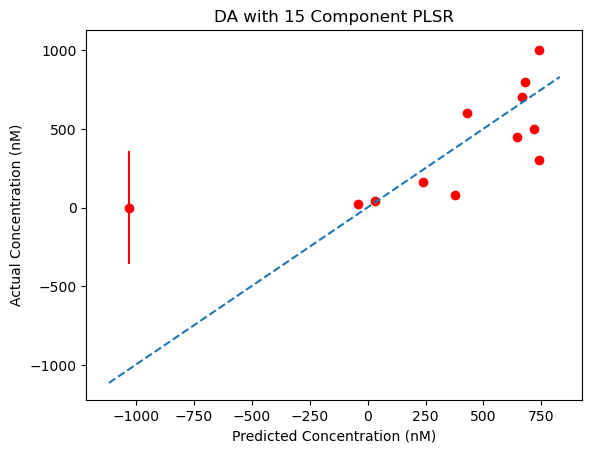

Num comps is 15
R2=0.6094936407362599
   Predicted (nM) Actual (nM) Std Dev (nM)
                0           0            0
0      143.570472         0.0   159.833448
1       10.164840        10.0    10.339337
2       86.415687        20.0    11.172914
3       49.543980        40.0    12.298164
4       37.487043        60.0    10.535470
5      241.574090       120.0    11.804716
6      159.495492       160.0    12.809115
7      270.112268       250.0    51.569674
8      451.601631       300.0    19.005912
9      340.317518       350.0    17.540112
10     356.160375       500.0    13.402420


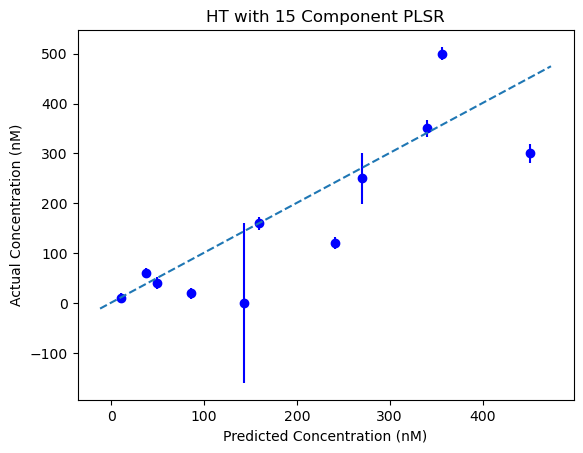

In [18]:
#can run loop to make predictions with range of components if desired 

for analyte in analyte_list:
    for j in np.arange(14,15):
        print("Num comps is "+str(j+1))
        groups = np.array(y_train[analyte]).flatten()

        logo = LeaveOneGroupOut()
        #print(logo.get_n_splits(X_train.T, np.array(y_train).flatten(), groups))

        for i, (train_index, test_index) in enumerate(logo.split(X_train.T, np.array(y_train[analyte]).flatten(), groups)):
            continue 
            #print(f"  Train: index={train_index}, group={groups[train_index]}")
            #print(f"  Test:  index={test_index}, group={groups[test_index]}")
        y_trainCV=np.array(y_train[analyte]).flatten()[train_index]
        y_trainCV=pd.DataFrame(y_trainCV)
        #print(y_trainCV)

        test_pred_avgs=[]
        test_act_avgs = []
        test_pred_std =[]

        for i, (train_index, test_index) in enumerate(logo.split(X_train.T, np.array(y_train[analyte]).flatten(), groups)):
            X_trainCV=X_train.T.iloc[train_index,:]
            X_trainCV=pd.DataFrame(X_trainCV)
            #print(X_trainCV)
            y_trainCV=np.array(y_train[analyte]).flatten()[train_index]
            y_trainCV=pd.DataFrame(y_trainCV)
            #print(y_trainCV)
            X_testCV=X_train.T.iloc[test_index,:]
            X_testCV=pd.DataFrame(X_testCV)
            #print(X_testCV)
            y_testCV=np.array(y_train[analyte]).flatten()[test_index]
            y_testCV=pd.DataFrame(y_testCV)
            #print(y_testCV)
            modelCV = set_model(modelChoice,X_trainCV,y_trainCV,j+1,preprocesser)
            results=modelCV.predict(X_testCV)
            #print(results)
            #print(np.mean(results))
            test_pred_avgs.append(np.mean(results))
            test_act_avgs.append(np.mean(y_testCV.values.tolist()))
            test_pred_std.append(np.std(results))
            #print(np.mean(y_testCV.values.tolist()))
        print('R2='+ str(r2_score(test_pred_avgs,test_act_avgs)))
        table = pd.concat(
            [pd.DataFrame(test_pred_avgs),pd.DataFrame(test_act_avgs),pd.DataFrame(test_pred_std)],
            axis=1,keys=['Predicted (nM)','Actual (nM)', 'Std Dev (nM)'])
        print(table)
        plt.scatter(test_pred_avgs,test_act_avgs,color=cmap[analyte])
        plt.errorbar(test_pred_avgs,test_act_avgs,test_pred_std,fmt='None',color=cmap[analyte])
        plt.xlabel('Predicted Concentration (nM)')
        plt.ylabel('Actual Concentration (nM)')
        plt.title(str(analyte)+' with '+str(j+1)+' Component '+ modelChoice)
        abline(1,1)
        plt.show()
        #print(test_pred_avgs,test_act_avgs,test_pred_std)

# Making Predictions and Calculating Metrics

In [22]:
df_testConc=pd.DataFrame({"Actual DA (nM)": y_test['DA'],"Actual 5HT (nM)": y_test['HT']})

actualDA = df_testConc['Actual DA (nM)'].to_numpy()
actualHT = df_testConc['Actual 5HT (nM)'].to_numpy()


In [23]:
df_metrics = pd.DataFrame({'N Comps': [],'MAE DA 0-T4':[],'MAE 5HT 0-T4':[],
                          })

In [28]:
scanInterval = 51

Running 15 component model...
                   DA                    HT
0  [0.97874163173255]                   NaN
1                 NaN  [0.9550854361745875]


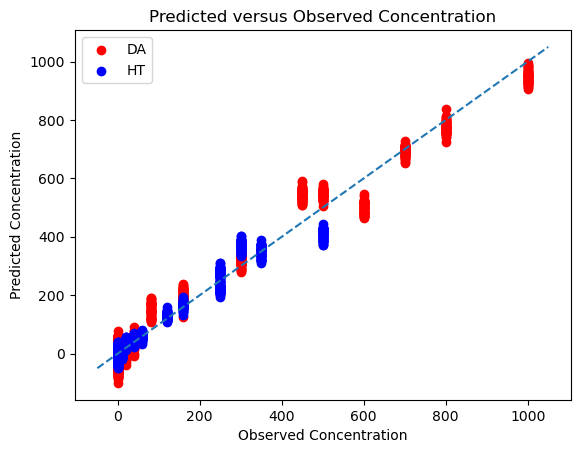

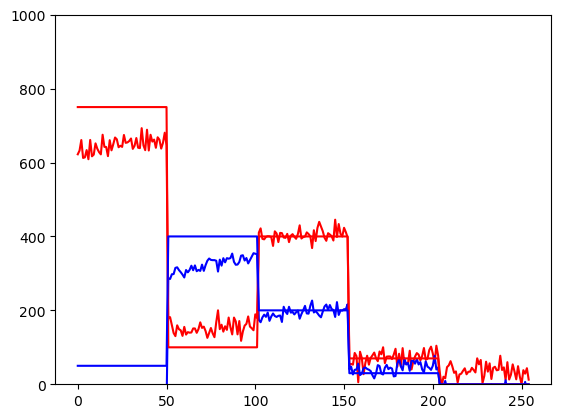

                     DA                    HT
0  [0.9581181812857542]                   NaN
1                   NaN  [0.8172472715776876]
DA test prediction correlation: 0.9581
5HT test prediction correlation: 0.8172


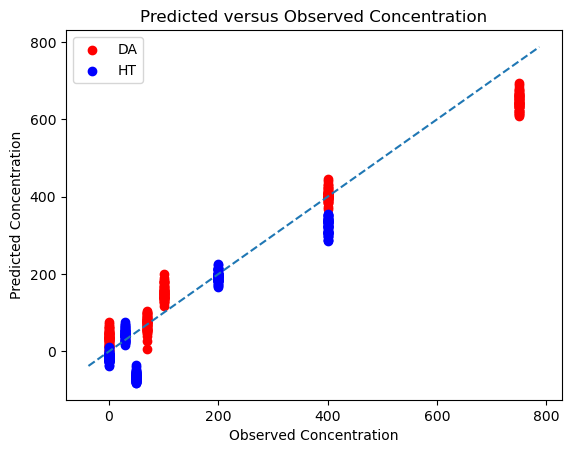

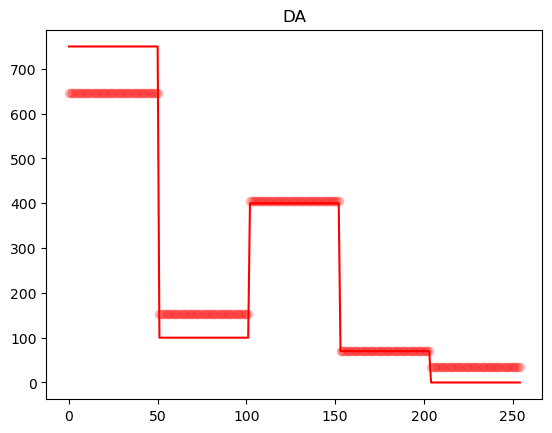

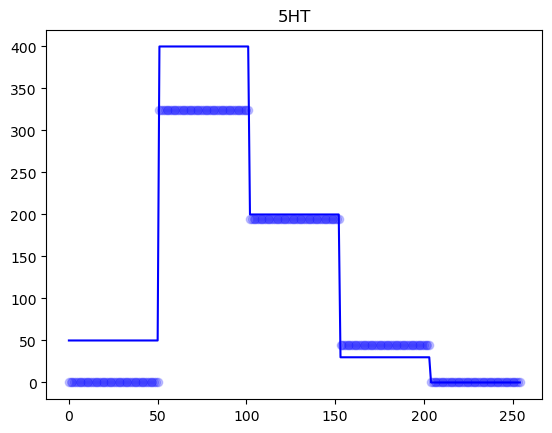

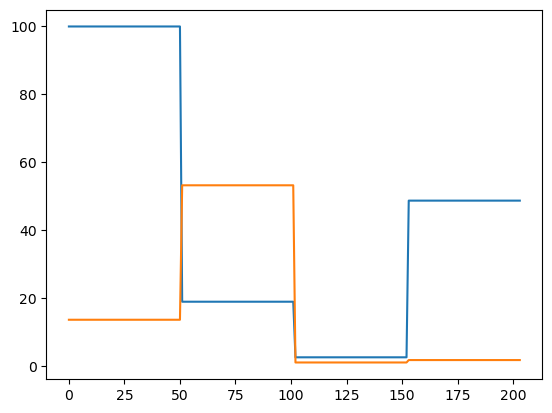

Analysis Complete!
   N Comps  MAE DA 0-T4  MAE 5HT 0-T4
0     15.0    43.559507     30.965058


In [29]:
finalComps=[15]
entry=0
for i in finalComps:
    
    df_metrics.at[entry,'N Comps']=i
    print('Running ' + str(i) + ' component model...')
    
    model = set_model(modelChoice,X_train.T,y_train,i,preprocesser)
    calibration_curves(model,X_train.T,y_train,analyte_list,cmap)
    plt.show()
    #vip(model)
    #plt.show()
    results = model.predict(X_test.T)
    df_results=pd.DataFrame({"Predicted DA (nM)": np.round(results[:,0],4),
                             "Predicted 5HT (nM)": np.round(results[:,1],4)})
    
    predDA = df_results['Predicted DA (nM)'].to_numpy()
    predHT = df_results['Predicted 5HT (nM)'].to_numpy()
    
    predDA[predDA < 0] = 0
    predHT[predHT < 0] = 0
    
    plt.plot(results[:,0],label='DA',color='r');
    plt.plot(results[:,1],label='HT',color='b');
    plt.plot(range(len(y_test.iloc[:,0])),y_test.iloc[:,0],color='r',label='DA')
    plt.plot(range(len(y_test.iloc[:,1])),y_test.iloc[:,1],color='b',label='HT')
    plt.ylim([0,1000])
    plt.show()
    calibration_curves(model,X_test.T,y_test,analyte_list,cmap)
    print('DA test prediction correlation: '+ str(np.round(r2_score(y_test.iloc[:,0],results[:,0]),4)))
    print('5HT test prediction correlation: '+ str(np.round(r2_score(y_test.iloc[:,1],results[:,1]),4)))
    
    plt.show()
    
    #create variable of same size
    avgDA=np.full_like(predDA,0)
    avgHT=np.full_like(predHT,0)
    
    #fill variable with average prediction 
    for m in range(int(len(df_results)/scanInterval)):
        avgDA[m*scanInterval:(m+1)*scanInterval]=(np.mean(predDA[m*scanInterval:(m+1)*scanInterval]))
        avgHT[m*scanInterval:(m+1)*scanInterval]=(np.mean(predHT[m*scanInterval:(m+1)*scanInterval]))
    
    #fill variable with absolute error  
    errorDA=np.absolute(predDA-actualDA)
    errorHT=np.absolute(predHT-actualHT)
    
    #plot and print DA predictions/averages/errors
    plt.scatter(range(len(avgDA)),avgDA,color='r',alpha=0.2)
    plt.plot(actualDA,color='r')
    plt.title('DA')
    plt.show()
    
    df_metrics.at[entry,'MAE DA 0-T4']=np.mean(errorDA[:5*scanInterval])
              
    #plot and print 5HT predictions/averages/errors
    plt.scatter(range(len(avgHT)),avgHT,color='b',alpha=0.2)
    plt.plot(actualHT,color='b')
    plt.title('5HT')
    plt.show()
    
    plt.plot(abs((avgHT-actualHT)/actualHT)*100)
    plt.plot(abs((avgDA-actualDA)/actualDA)*100)
    plt.show()

    df_metrics.at[entry,'MAE 5HT 0-T4']=np.mean(errorHT[:5*scanInterval])
    
    entry+=1
    
print("Analysis Complete!")
print(df_metrics)

In [30]:
df_metrics

,N Comps,MAE DA 0-T4,MAE 5HT 0-T4
0,15.0,43.559507,30.965058


These results will be useful for our Bayesian optimization notebook.

# Saving the Model

We've put a lot of work and time into training, validating and test this model. When we close this notebook, we don't want to lose all that progress, of else we will have to retrain our model everytime.

To save our model, we can do the following.

In [39]:
def save_model(myModel,myFile):
    """"""
    pickle.dump(myModel, open(myFile, 'wb'))
    print('Saved model successfully!')
    
def load_model(myFile):
    ''''''
    file = open(myFile, 'rb')
    myModel = pickle.load(file)
    return myModel

In [40]:
save_model(model,'name_your_model_here')

Saved model successfully!


Then, next time you want to run this model, you can skip all the above steps and simply load the previous model.

In [42]:
loaded_model = load_model('name_your_model_here')

In [43]:
print(loaded_model)

Pipeline(steps=[('normalizer', Normalizer(norm='max')),
                ('plsregression', PLSRegression(n_components=15, scale=False))])


In [45]:
loaded_model.predict(X_test.T)

array([[ 6.22249060e+02, -6.27391604e+01],
       [ 6.32298861e+02, -6.59940638e+01],
       [ 6.60809501e+02, -7.69199112e+01],
       [ 6.12288641e+02, -5.95564217e+01],
       [ 6.13980841e+02, -7.47831706e+01],
       [ 6.33641678e+02, -6.06679278e+01],
       [ 6.08919759e+02, -6.29085549e+01],
       [ 6.61050538e+02, -6.95417592e+01],
       [ 6.16797314e+02, -6.44462020e+01],
       [ 6.21328399e+02, -5.67708503e+01],
       [ 6.51842560e+02, -8.14444927e+01],
       [ 6.37398796e+02, -8.13872087e+01],
       [ 6.28040660e+02, -4.74841764e+01],
       [ 6.22032326e+02, -7.45972578e+01],
       [ 6.75160940e+02, -6.38935531e+01],
       [ 6.42349303e+02, -6.32272133e+01],
       [ 6.42060142e+02, -7.36401933e+01],
       [ 6.17303110e+02, -3.63094156e+01],
       [ 6.60378708e+02, -5.81632550e+01],
       [ 6.32961171e+02, -7.89381843e+01],
       [ 6.49507592e+02, -8.03472880e+01],
       [ 6.67654256e+02, -7.94508068e+01],
       [ 6.62828431e+02, -6.88516878e+01],
       [ 6.

# Model Interpretation 

Text(0.5, 1.0, 'Total VIP Scores')

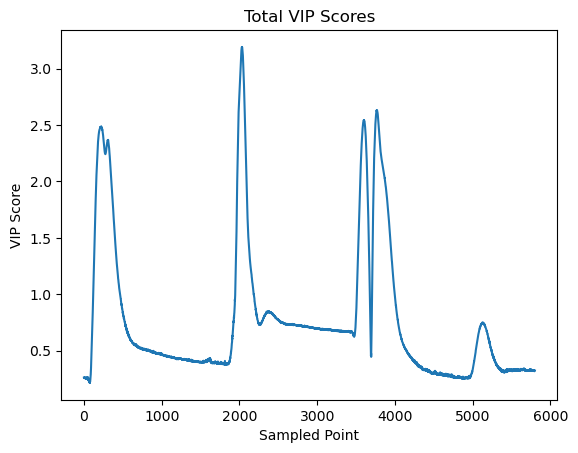

In [62]:
vip(model)
plt.title('Total VIP Scores')

We can also plot our waveform.

In [68]:
waveforms=[[]]

for i in waveforms:
    x_plt = [0,i[1],i[1],i[3]+i[1],i[3]+i[1],i[3]+i[1]+i[5],
         i[3]+i[1]+i[5],i[3]+i[1]+i[5]+i[7]]
    y_plt = [i[0],i[0],i[2],i[2],i[4],i[4],i[6],i[6]]
    x_plt = [element*1000 for element in x_plt]
    plt.plot(x_plt,y_plt);
    # setting title
    plt.title("Waveform", fontsize=20)
    # setting x-axis label and y-axis label
    plt.xlabel("Time (us)")
    plt.ylabel("Voltage (V)")
    plt.show()

IndexError: list index out of range

Text(0.5, 1.0, 'PLSR X-Loadings by Analyte')

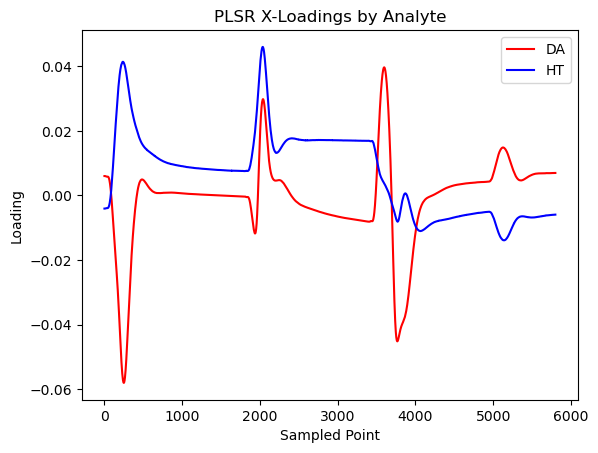

In [61]:
plt.plot((loaded_model.named_steps['plsregression'].x_loadings_)[:,0],color='r',label='DA')
plt.plot((loaded_model.named_steps['plsregression'].x_loadings_)[:,1],color='b',label='HT')
plt.legend()
plt.xlabel('Sampled Point')
plt.ylabel('Loading')
plt.title('PLSR X-Loadings by Analyte')

Text(0.5, 1.0, 'PLS Regression Coefficients by Analyte')

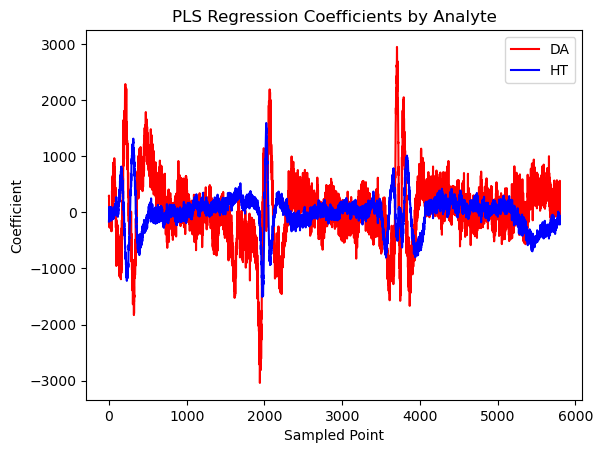

In [58]:
plt.plot((loaded_model.named_steps['plsregression'].coef_)[:,0],label='DA',color='r')
plt.plot((loaded_model.named_steps['plsregression'].coef_)[:,1],label='HT',color='b')
plt.legend()
plt.xlabel('Sampled Point')
plt.ylabel('Coefficient')
plt.title('PLS Regression Coefficients by Analyte')

If we want to visualize the individual VIP scores by analyte, we can augment the VIP function as such.

In [50]:
def vip_by_analyte(model,y_index):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_[y_index,:]
    q = np.reshape(q,(1,-1))
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

Text(0.5, 1.0, 'VIP Scores by Analyte')

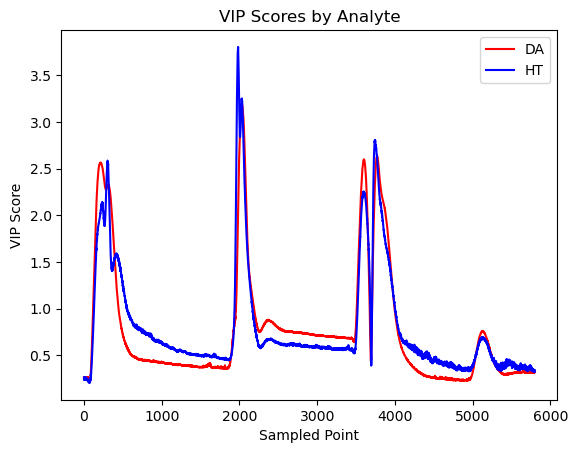

In [57]:
plt.plot(vip_by_analyte(loaded_model.named_steps['plsregression'],0),color='r',label='DA')
plt.plot(vip_by_analyte(loaded_model.named_steps['plsregression'],1),color='b',label='HT')
plt.legend()
plt.xlabel('Sampled Point')
plt.ylabel('VIP Score')
plt.title('VIP Scores by Analyte')

In [ ]:
reconstruct_voltammograms(X_train,modelChoice,nComps)